In [127]:
import pandas as pd

results = pd.read_csv('results.csv')         # Contains race outcomes
races = pd.read_csv('races.csv')             # Contains race dates & circuits
constructors = pd.read_csv('constructors.csv')  # Team info
drivers = pd.read_csv('drivers.csv')         # Driver info
status = pd.read_csv('status.csv')           # Status codes (for DNFs)

print(results.head())
print(races.head())
print(constructors.head())


   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300         1  
1         41    3 

In [128]:
df = pd.merge(results, races[['raceId', 'year', 'circuitId', 'name']], on='raceId', how='left')

df = pd.merge(df, constructors[['constructorId', 'name']], on='constructorId', how='left', suffixes=('', '_constructor'))

df = pd.merge(df, drivers[['driverId', 'forename', 'surname']], on='driverId', how='left')

df = pd.merge(df, status, on='statusId', how='left')

df.rename(columns={
    'name': 'race_name',
    'name_constructor': 'constructor_name',
    'forename': 'driver_first_name',
    'surname': 'driver_last_name',
    'status': 'race_status'
}, inplace=True)
print(df.head())


   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  ...  fastestLapTime fastestLapSpeed  \
0            1              1    10.0  ...        1:27.452         218.300   
1            2              2     8.0  ...        1:27.739         217.586   
2            3              3     6.0  ...        1:28.090         216.719   
3            4              4     5.0  ...        1:28.603         215.464   
4            5              5     4.0  ...        1:27.418         218.385   

  statusId  year circuitId              race_name constructor_name  \
0        1  2008         1  Australian G

In [129]:
df['dnf'] = df['statusId'].apply(lambda x: 0 if x == 1 else 1)

df['year'] = pd.to_numeric(df['year'], errors='coerce')

df.dropna(subset=['year', 'constructor_name', 'points'], inplace=True)

print(df[['year', 'constructor_name', 'points', 'dnf', 'race_name']].head())


   year constructor_name  points  dnf              race_name
0  2008          McLaren    10.0    0  Australian Grand Prix
1  2008       BMW Sauber     8.0    0  Australian Grand Prix
2  2008         Williams     6.0    0  Australian Grand Prix
3  2008          Renault     5.0    0  Australian Grand Prix
4  2008          McLaren     4.0    0  Australian Grand Prix


In [130]:
team_stats = df.groupby(['year', 'constructor_name']).agg({
    'points': 'sum',
    'dnf': 'sum',
    'raceId': 'nunique',  # Total races
    'positionOrder': lambda x: (x <= 3).sum()  # Total podiums
}).reset_index()

team_stats.rename(columns={
    'points': 'total_points',
    'dnf': 'total_dnfs',
    'raceId': 'total_races',
    'positionOrder': 'total_podiums'
}, inplace=True)

team_stats['avg_points_per_race'] = team_stats['total_points'] / team_stats['total_races']
team_stats['dnf_rate'] = team_stats['total_dnfs'] / team_stats['total_races']

# ✅ Preview Aggregated Data
print(team_stats.head())


   year constructor_name  total_points  total_dnfs  total_races  \
0  1950            Adams           0.0           2            1   
1  1950       Alfa Romeo          89.0           9            6   
2  1950             Alta           0.0           3            2   
3  1950           Cooper           0.0           1            1   
4  1950            Deidt          10.0           3            1   

   total_podiums  avg_points_per_race  dnf_rate  
0              0             0.000000       2.0  
1             12            14.833333       1.5  
2              0             0.000000       1.5  
3              0             0.000000       1.0  
4              2            10.000000       3.0  


In [131]:
# Calculate Year-over-Year Change in Performance
team_stats['prev_points'] = team_stats.groupby('constructor_name')['total_points'].shift(1)
team_stats['points_change'] = team_stats['total_points'] - team_stats['prev_points']
team_stats['points_change_pct'] = team_stats['points_change'] / team_stats['prev_points']

# Fill NaN for first season entries
team_stats.fillna(0, inplace=True)

# Label Underperformance (Historical)
# Teams with negative growth & low avg points
team_stats['underperformed'] = ((team_stats['points_change_pct'] < -0.1) & 
                                (team_stats['avg_points_per_race'] < team_stats['avg_points_per_race'].mean())).astype(int)

# Preview Data
print(team_stats)


      year constructor_name  total_points  total_dnfs  total_races  \
0     1950            Adams           0.0           2            1   
1     1950       Alfa Romeo          89.0           9            6   
2     1950             Alta           0.0           3            2   
3     1950           Cooper           0.0           1            1   
4     1950            Deidt          10.0           3            1   
...    ...              ...           ...         ...          ...   
1106  2024         Mercedes         433.0           5           24   
1107  2024       RB F1 Team          40.0          29           24   
1108  2024         Red Bull         537.0           9           24   
1109  2024           Sauber           4.0          37           24   
1110  2024         Williams          17.0          33           24   

      total_podiums  avg_points_per_race  dnf_rate  prev_points  \
0                 0             0.000000  2.000000          0.0   
1                12      

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
# Select Features and Target
features = ['avg_points_per_race', 'dnf_rate', 'total_podiums']
target = 'underperformed'

X = team_stats[features]
y = team_stats[target]
print(X)
print(y)
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with 0 (or use another imputation strategy)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Now fit the model
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate Model
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


      avg_points_per_race  dnf_rate  total_podiums
0                0.000000  2.000000              0
1               14.833333  1.500000             12
2                0.000000  1.500000              0
3                0.000000  1.000000              0
4               10.000000  3.000000              2
...                   ...       ...            ...
1106            18.041667  0.208333              9
1107             1.666667  1.208333              0
1108            22.375000  0.375000             18
1109             0.166667  1.541667              0
1110             0.708333  1.375000              0

[1111 rows x 3 columns]
0       0
1       0
2       0
3       0
4       0
       ..
1106    0
1107    0
1108    0
1109    1
1110    1
Name: underperformed, Length: 1111, dtype: int64
Accuracy: 0.7544910179640718
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       258
           1       0.44      0.29      0.35        76

    accurac

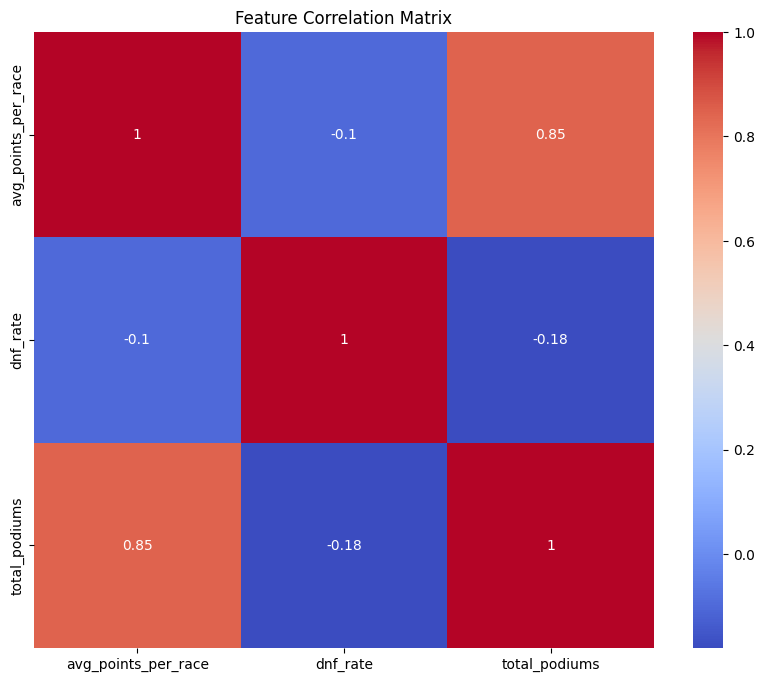

In [133]:
# Check for highly correlated features
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X_train).corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [134]:
# Evaluate on Training Set
y_train_pred = rf_model.predict(X_train)
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Evaluate on Test Set (Already Done)
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.9472329472329473
Test Accuracy: 0.7544910179640718


In [135]:
from sklearn.model_selection import cross_val_score

# Cross-Validation (5-fold)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

print("Cross-Validation Scores:", cv_scores)
print("Average CV Score:", cv_scores.mean())


Cross-Validation Scores: [0.76282051 0.73717949 0.8        0.78064516 0.76774194]
Average CV Score: 0.7696774193548387


In [136]:
# Prepare 2024 Data as the Latest Available
latest_season = team_stats[team_stats['year'] == 2024]

# Drop Target Column for Prediction
X_2025 = latest_season[features]

# Predict Underperformance
latest_season['underperformance_risk'] = rf_model.predict_proba(X_2025)[:, 1]  # Probability of underperformance

# Sort by Highest Risk
underperformance_ranking = latest_season.sort_values(by='underperformance_risk', ascending=False)

# Display Teams Likely to Underperform in 2025
print(underperformance_ranking[['constructor_name', 'underperformance_risk', 'avg_points_per_race', 'dnf_rate']])


     constructor_name  underperformance_risk  avg_points_per_race  dnf_rate
1109           Sauber                   0.86             0.166667  1.541667
1110         Williams                   0.79             0.708333  1.375000
1101   Alpine F1 Team                   0.48             2.625000  1.250000
1104     Haas F1 Team                   0.33             2.125000  0.875000
1102     Aston Martin                   0.06             3.916667  0.916667
1107       RB F1 Team                   0.06             1.666667  1.208333
1106         Mercedes                   0.00            18.041667  0.208333
1105          McLaren                   0.00            25.375000  0.041667
1103          Ferrari                   0.00            24.791667  0.208333
1108         Red Bull                   0.00            22.375000  0.375000


/tmp/ipykernel_228509/4265471269.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_season['underperformance_risk'] = rf_model.predict_proba(X_2025)[:, 1]  # Probability of underperformance
